<h1 align="center">MSIN0097: Predictive Analytics </h1>
<h1 align="center">Individual Coursework</h1>
<h1 align="center">Predicting NYC Taxi Trip Duration</h1>
<br><br><br>
<h3 align="center">Word Count: 1732</h3>

**Link to Jupyter notebook on Github**: https://github.com/noe-vaz/MSIN0097-Individual-Assignment/upload

<h3>Table of Contents</h3>

* [1. Introduction](#1.-Introduction)
    * [1.1. Overview of the Problem](#1.1.-Overview-of-the-Problem)
* [2. Data Cleaning](#2.-Data-Cleaning)
    * [2.1. Overview of the Dataset](#2.1.-Overview-of-the-Dataset)
    * [2.2. Initial Data Cleaning](#2.2.-Initial-Data-Cleaning)
* [3. Exploratory Data Analysis](#3.-Exploratory-Data-Analysis)
* [4. Machine Learning Models](#4.-Machine-Learning-Models)
    * [4.1. More Data Preprocessing](#4.1.-More-Data-Preprocessing)
    * [4.2. Linear Regression](#4.2.-Linear-Regression)
    * [4.3. Elastic Net Regression](#4.3.-Elastic-Net-Regression)
    * [4.4. Ridge Regression](#4.4.-Ridge-Regression)
    * [4.5. Decision Tree Regression](#4.5.-Decision-Tree-Regression)
    * [4.6. Random Forests Regression](#4.6.-Random-Forests-Regression)
    * [4.7. XGBoost Regression](#4.7.-XGBoost-Regression)
    * [4.8. Voting Regressor](#4.8.-Voting-Regressor)
* [5. Fine-tuning Models](#5.-Fine-tuning-Models)
    * [5.1. Random Forests Fine-tuning](#5.1.-Random-Forests-Fine-tuning)
    * [5.2. XGBoost Fine-tuning](#5.2.-XGBoost-Fine-tuning)
    * [5.3. Voting Regressor with Tuned Models](#5.3.-Voting-Regressor-with-Tuned-Models)
* [6. Summary](#6.-Summary)
* [7. Limitations](#7.-Limitations)
* [8. References](#8.-References)

In [172]:
pip install xgboost


         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.                  

• Project files and data should be stored in /project. This is shared among everyone
  in the project.
• Personal files and configuration should be stored in /home/faculty.
• Files outside /project and /home/faculty will be lost when this server is terminated.
• Create custom environments to setup your servers reproducibly.

Note: you may need to restart the kernel to use updated packages.


# 1. Introduction

## 1.1. Overview of the Problem

NYC is well known for its issue with congestion and the high traffic on its road. As a matter of fact, it was the most congested city in the US in 2020. This makes going from point A to point B pretty unpredictable. 

In this analysis we would like to investigate and be able to predict the duration of a cab trip in NYC (given a certain pickup point and dropoff point). 
Following this analysis, we would hope to be able to recommend the fastest route and to go from point A to point B be less of a headache for anyone travelling in NYC who needs to be on time.

We will first perform some data cleaning, then move on to data visualisation, data pre-processing and finally running our models and fine-tuning them to get the most performing model possible. 

# 2. Data Cleaning and Feature Engineering

## 2.1. Overview of the Dataset

Our dataset is sourced from Kaggle: https://www.kaggle.com/c/nyc-taxi-trip-duration/data

We will make predictions on the duration of a NYC taxi trip using regression analysis. 

The variables in our dataset are as follows:
- **id** - a unique identifier for each trip
- **vendor_id** - a code indicating the provider associated with the trip record
- **pickup_datetime** - date and time when the meter was engaged
- **dropoff_datetime** - date and time when the meter was disengaged
- **passenger_count** - the number of passengers in the vehicle (driver entered value)
- **pickup_longitude** - the longitude where the meter was engaged
- **pickup_latitude** - the latitude where the meter was engaged
- **dropoff_longitude** - the longitude where the meter was disengaged
- **dropoff_latitude** - the latitude where the meter was disengaged
- **store_and_fwd_flag** - this flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
- **trip_duration** - duration of the trip in seconds

## 2.2. Data Cleaning

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
import xgboost

from scipy import stats
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

In [2]:
#loading the data
df1 = pd.read_csv("/project/train_NYC_trip.csv")

In [3]:
#making the dataset easier to read
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
df1.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435


In [5]:
#checking the number of rows
df1.shape

(1458644, 11)

Our dataset is really large. This would be too computationally exhausting when running machine learning models and trying to optimise them. 

Therefore, we only keep the first 50,000 rows of the dataset. Since the dataset does not seem to be in any specific order (the pick-up and dropoff dates and times are not in sequential order), it would be safe to assume that it would not introduce too strong a bias. 

In [6]:
#reduce the size of the dataset for manageability
df_trip = df1[:50000]
#checking the first 15 rows to make sure the values are not in order
df_trip.head(15)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.983,40.742,-73.992,40.749,N,443
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969,40.758,-73.957,40.766,N,341
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969,40.798,-73.922,40.761,N,1551
8,id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999,40.738,-73.986,40.733,N,255
9,id0012891,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.981,40.744,-73.973,40.790,N,1225


In [7]:
#we now have 50,000 rows and 11 variables
df_trip.shape

(50000, 11)

In [8]:
#let's check for null values
df_trip.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

There seems to be no missing values in our dataset. We can now deep dive into the dataset and check for anomalities.

In [9]:
#let's check the dataset
df_trip.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000,50000.000
mean,1.529,1.667,-73.973,40.751,-73.973,40.752,949.708
std,0.499,1.316,0.038,0.028,0.037,0.033,3175.391
min,1.000,1.000,-74.394,40.450,-74.399,40.445,1.000
25%,1.000,1.000,-73.992,40.738,-73.991,40.736,395.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,659.000
75%,2.000,2.000,-73.967,40.769,-73.963,40.770,1071.000
max,2.000,6.000,-73.518,41.091,-72.711,41.312,86357.000


When looking at the descriptive table above, there seems to be a large gap between the minimum and maximum values in the 'trip_duration' variable. The shortest trip lasted 1 second while the longest trip lasted over 23 hours. It is safe to assume that these are outliers and may be due to a fault in the duration recording system (or someone really decided to drive around New York in a taxi cab for a whole day).

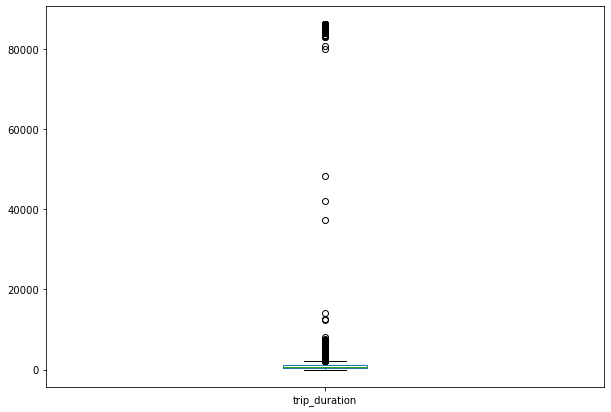

In [10]:
#visualising the outliers
df_trip["trip_duration"].plot.box(figsize = (10, 7))
plt.show()

To avoid strong bias from these outliers later on in our models, we get rid of outliers that are 3 standard deviations from the mean.

In [11]:
#dealing with outliers
mean = np.mean(df_trip['trip_duration'])
std = np.std(df_trip['trip_duration'])
df_trip = df_trip[df_trip['trip_duration'] <= mean + 3*std]

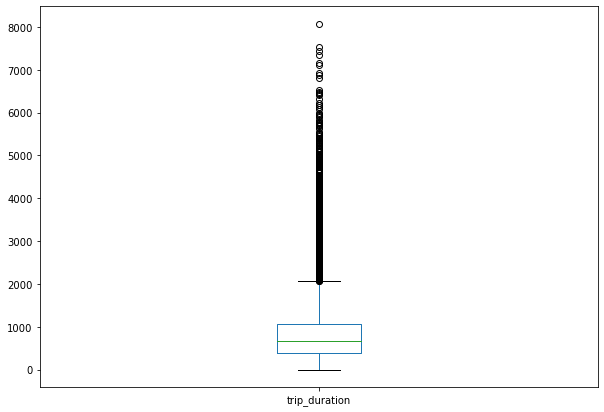

In [12]:
#looking at our outliers again
df_trip["trip_duration"].plot.box(figsize = (10, 7))
plt.show()

Our outliers are much better. The longest trip is now 8,000 seconds, which approximates 2 hours (much more realistic). 

We can now move on to some data processing and feature engineering for EDA. 

## 2.3. Data Preprocessing and Feature Engineering 

### Date clean-up

To make our data exploratory analysis easier, we convert our 'pick up datetime' and 'dropoff date time' variables to datetime. 

In [13]:
df_trip['pickup_datetime'] = pd.to_datetime(df_trip.pickup_datetime)
df_trip.loc[:, 'pickup_date'] = df_trip['pickup_datetime'].dt.date
df_trip['dropoff_datetime'] = pd.to_datetime(df_trip.dropoff_datetime)

In [14]:
df_trip.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
trip_duration                  int64
pickup_date                   object
dtype: object

We also create new date variables by splitting our 'pick up datetime' variable into days, day of the week, month and hour. This will make it possible to observe more specific trends or patterns in our data.

In [15]:
df_trip['month'] = df_trip['pickup_datetime'].dt.month
df_trip['day_of_month'] = df_trip['pickup_datetime'].dt.day
df_trip['hour'] = df_trip['pickup_datetime'].dt.hour
df_trip['day_of_week'] = df_trip['pickup_datetime'].dt.dayofweek

In [16]:
df_trip.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,month,day_of_month,hour,day_of_week
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455,2016-03-14,3,14,17,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663,2016-06-12,6,12,0,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124,2016-01-19,1,19,11,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429,2016-04-06,4,6,19,2
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435,2016-03-26,3,26,13,5


In [17]:
#check to see if the date variables are correct
df_trip.groupby('month').size()

month
1    7959
2    8166
3    8612
4    8710
5    8473
6    8007
dtype: int64

In [18]:
len(df_trip.groupby('day_of_month').size())

31

In [19]:
len(df_trip.groupby('day_of_week').size())

7

In [20]:
len(df_trip.groupby('hour').size())

24

array([[<AxesSubplot:title={'center':'vendor_id'}>,
        <AxesSubplot:title={'center':'passenger_count'}>,
        <AxesSubplot:title={'center':'pickup_longitude'}>],
       [<AxesSubplot:title={'center':'pickup_latitude'}>,
        <AxesSubplot:title={'center':'dropoff_longitude'}>,
        <AxesSubplot:title={'center':'dropoff_latitude'}>],
       [<AxesSubplot:title={'center':'store_and_fwd_flag'}>,
        <AxesSubplot:title={'center':'trip_duration'}>,
        <AxesSubplot:title={'center':'month'}>],
       [<AxesSubplot:title={'center':'day_of_month'}>,
        <AxesSubplot:title={'center':'hour'}>,
        <AxesSubplot:title={'center':'day_of_week'}>]], dtype=object)

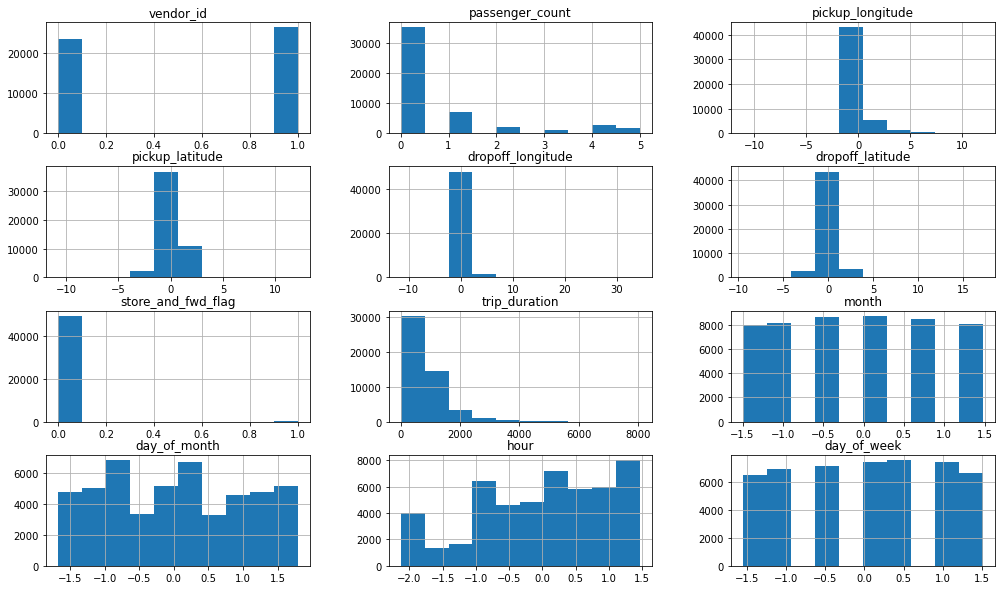

In [89]:
df_trip.hist(figsize = (17,10))

# 3. Exploratory Data Analysis

### Trip duration

<AxesSubplot:xlabel='trip_duration', ylabel='Density'>

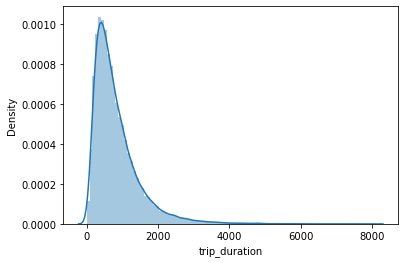

In [21]:
sns.distplot(df_trip["trip_duration"], bins =100)

Our trip duration variable seems to be skewed to the right. We take the log and visualise it below.

In [22]:
df_trip['log_trip_duration'] = np.log(df_trip['trip_duration'].values + 1)

<AxesSubplot:xlabel='log_trip_duration', ylabel='Density'>

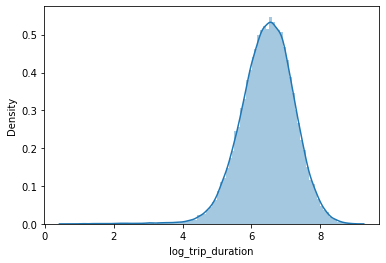

In [23]:
sns.distplot(df_trip["log_trip_duration"], bins =100)

### Vendors

In [24]:
df_trip['vendor_id'].value_counts()

2    26400
1    23527
Name: vendor_id, dtype: int64

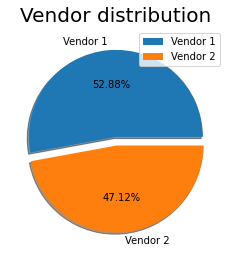

In [25]:
#creating a pie chart
labels = ['Vendor 1', 'Vendor 2']
explode = [0, 0.1]
sizes = df_trip['vendor_id'].value_counts()

plt.pie(sizes, labels = labels, shadow = True, explode = explode, autopct = '%.2f%%')
plt.title('Vendor distribution', fontsize = 20)
plt.legend()
plt.show()

Text(0, 0.5, 'Duration in seconds')

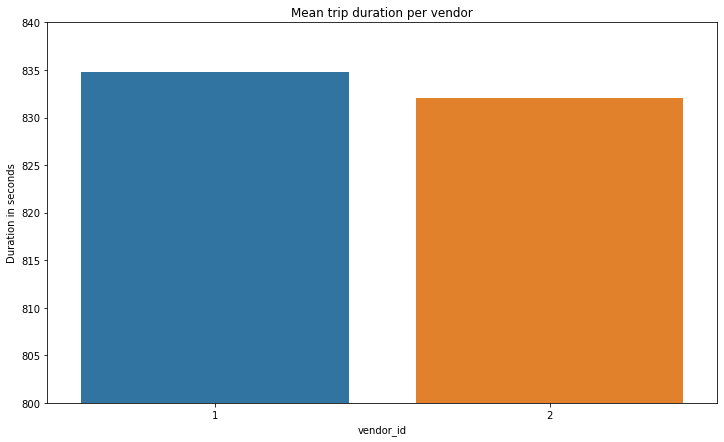

In [26]:
plot_vendor = df_trip.groupby('vendor_id')['trip_duration'].mean()
plt.subplots(1,1,figsize=(12,7))
plt.ylim(ymin=800)
plt.ylim(ymax=840)
sns.barplot(plot_vendor.index,plot_vendor.values)
plt.title('Mean trip duration per vendor')
plt.ylabel('Duration in seconds')

The graphs above show no great disparities between vendor 1 and vendor 2, both in terms of proportion and in terms of the mean duration of taxi trips. Therefore, we could assume that none of the vendors is introducing bias into our dataset because one vendor's employees are less efficient and using longer routes than the other. 

### Passenger count

In [27]:
df_trip['passenger_count'].value_counts()

1    35344
2     7211
5     2680
3     2031
6     1654
4     1007
Name: passenger_count, dtype: int64

<AxesSubplot:title={'center':'Passenger count'}>

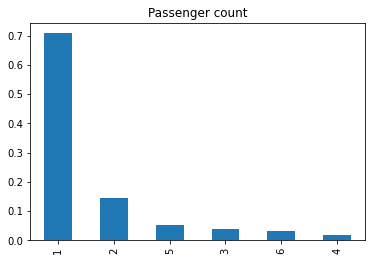

In [28]:
df_trip['passenger_count'].value_counts()
df_trip['passenger_count'].value_counts(normalize = True).plot.bar(title = 'Passenger count')

Text(0, 0.5, 'Duration in seconds')

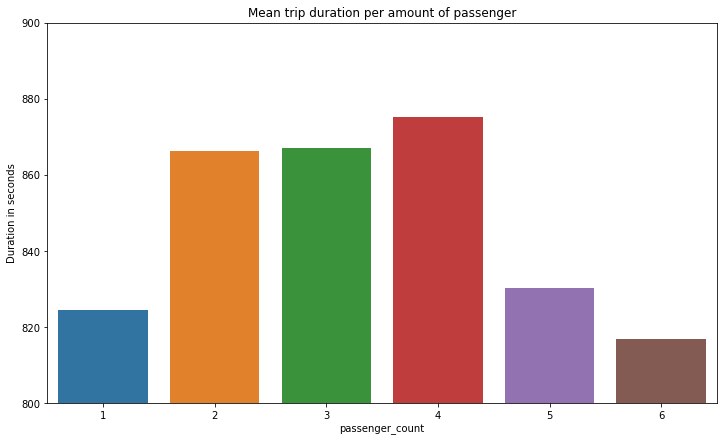

In [29]:
plot_passenger = df_trip.groupby('passenger_count')['trip_duration'].mean()
plt.subplots(1,1,figsize=(12,7))
plt.ylim(ymin=800)
plt.ylim(ymax=900)
sns.barplot(plot_passenger.index,plot_passenger.values)
plt.title('Mean trip duration per amount of passenger')
plt.ylabel('Duration in seconds')

There is a larger amount of solo taxi trips in our dataset. However, the longest rides seem to be on rides with 3 and 4 passengers. This could simply because more passengers mean more stops and a longer trip duration. It could also be that people are more likely to travel with others when going further away as to split the fare. 

### Store and forward flag

In [39]:
df_trip['store_and_fwd_flag'].value_counts()

N    49633
Y      294
Name: store_and_fwd_flag, dtype: int64

Text(0, 0.5, 'Duration in seconds')

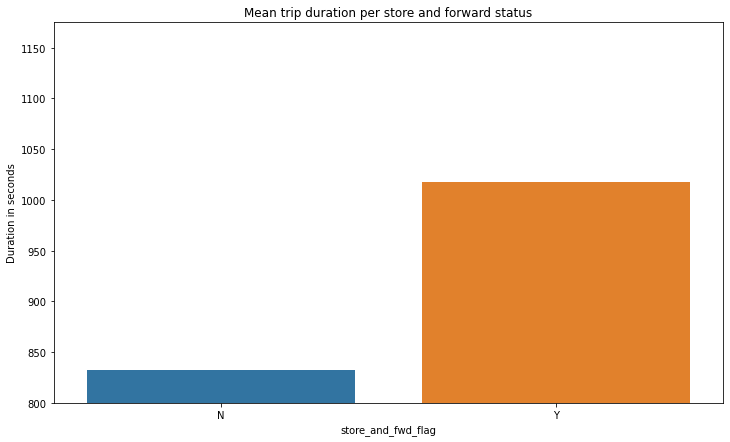

In [47]:
plot_fwd = df_trip.groupby('store_and_fwd_flag')['trip_duration'].mean()
plt.subplots(1,1,figsize=(12,7))
plt.ylim(ymin=800)
plt.ylim(ymax=1175)
sns.barplot(plot_fwd.index,plot_fwd.values)
plt.title('Mean trip duration per store and forward status')
plt.ylabel('Duration in seconds')

The mean duration of a trip is significantly greater when the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server. Therefore, a fault in server connection may create bias in the dataset since it might record trips as longer than they really were. 

### Date and time variables

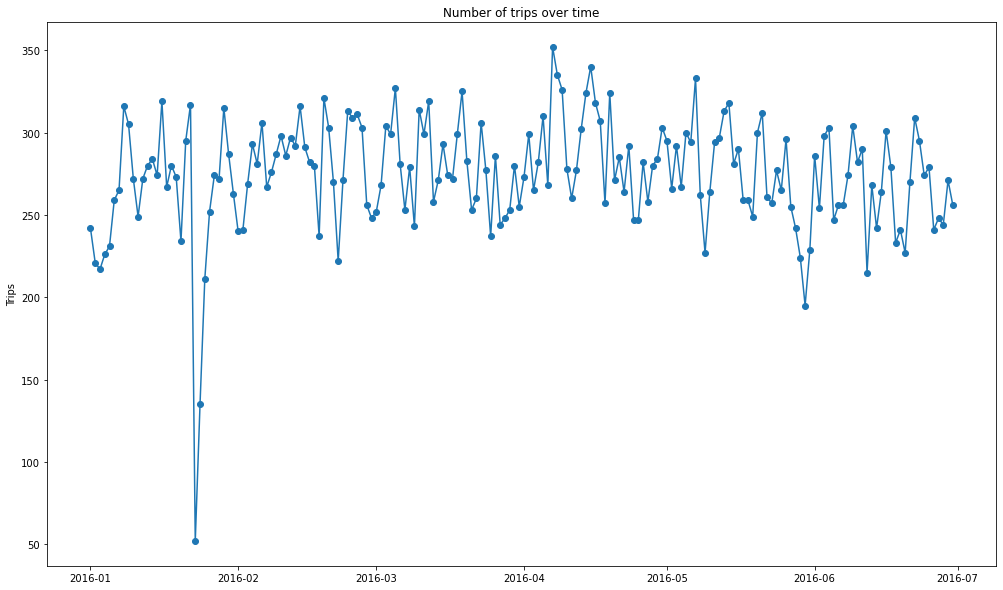

In [30]:
#timeseries plot of the fluctuation of daily trips across a 6 months period
plt.figure(figsize = (17, 10))
plt.plot(df_trip.groupby('pickup_date').count()[['id']], 'o-')
plt.title('Number of trips over time')
plt.ylabel('Trips')
plt.show()

We create a timeseries plot to visualise the amount of rides over the dataset period. It seems to fluctuate a lot with the days and months. One specific pattern that is noticable is the drop in trips around February. It might be due to bad weather, strikes or even a fault in the recording server.

Now we look at specific trends and patterns in a day, a week and a month. 

Text(0, 0.5, 'Trip duration')

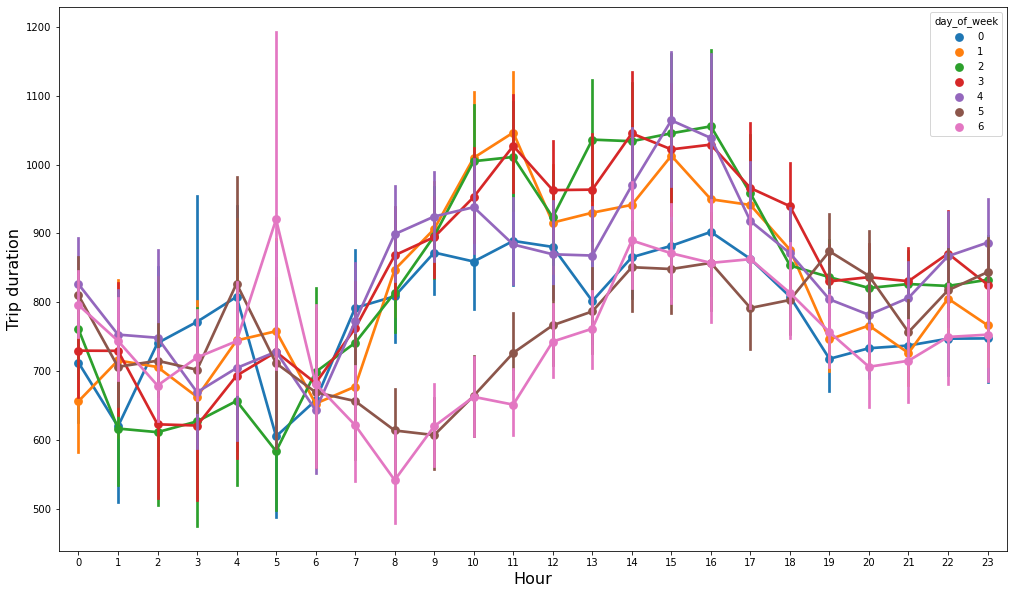

In [35]:
#create a pointplot of the fluctuation of trip durations per hour and day of the week
plt.figure(figsize=(17,10))
sns.pointplot(x = 'hour',y = 'trip_duration', data = df_trip, kind = 'point', hue = 'day_of_week')
plt.xlabel('Hour',fontsize=16)
plt.ylabel('Trip duration',fontsize=16)

There seems to be a general trend of trip duration increasing between 9am and 3pm (rush hour) for everyday of the week except Saturdays and Fridays (days 5 and 6). 

Another notable peak is on Sunday (day 6) at around 5am. It could be potentially explained by people going home from the bar/club and not having access to public transport.

Text(0, 0.5, 'Trip duration')

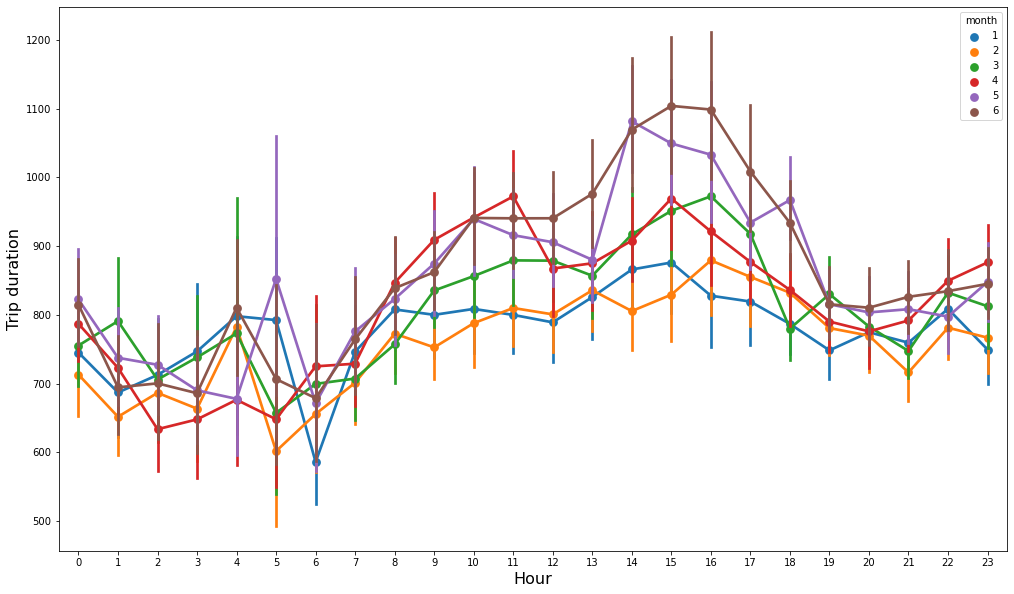

In [37]:
#creating a pointplot of the fluctuation of trip duration for each hour of every month
plt.figure(figsize=(17,10))
sns.pointplot(x = 'hour',y = 'trip_duration', data = df_trip, hue = 'month')
plt.xlabel('Hour',fontsize=16)
plt.ylabel('Trip duration',fontsize=16)

There is a general trend in the ride duration increasing between 5 and 8pm for every month. 

Text(0, 0.5, 'Trip duration')

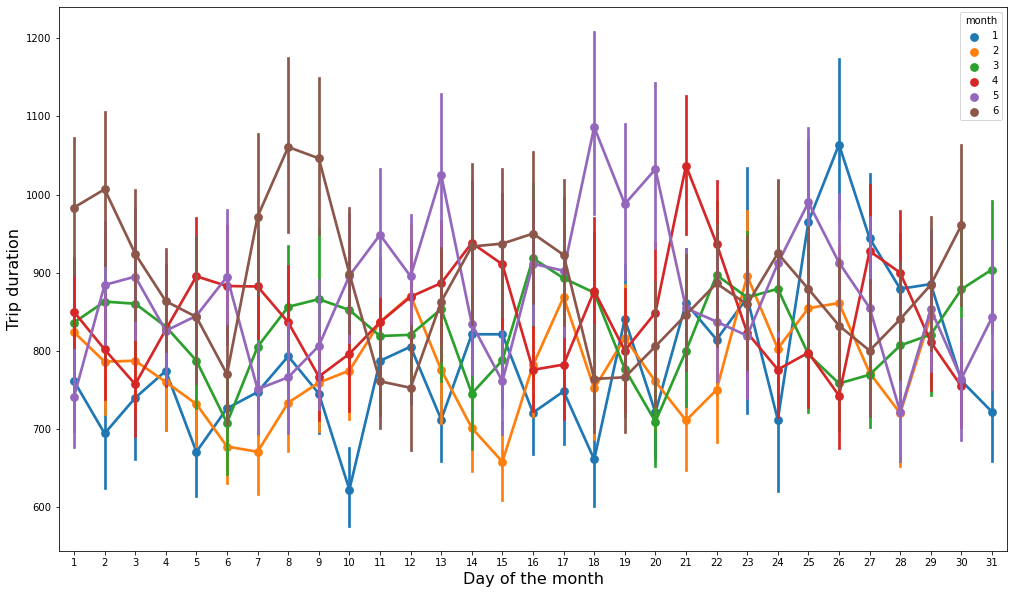

In [38]:
#creating a pointplot of the fluctuation of trip duration per day of the month and month
plt.figure(figsize=(17,10))
sns.pointplot(x = 'day_of_month', y = 'trip_duration', data = df_trip, kind = 'point', hue = 'month')
plt.xlabel('Day of the month',fontsize=16)
plt.ylabel('Trip duration',fontsize=16)

Finally, when looking at the plot above, we cannot distinguish any pattern between day of the month and the month itself. 

### Pickup and dropoff locations

As an extra step to make visualisations more accurate, we constrain the latitude and longitude to be within the borders of New-York City. These should be: 

- Latitude (40.6, 40.9)
- Longitude (-74.05, -73.70)

Text(0, 0.5, 'Latitude')

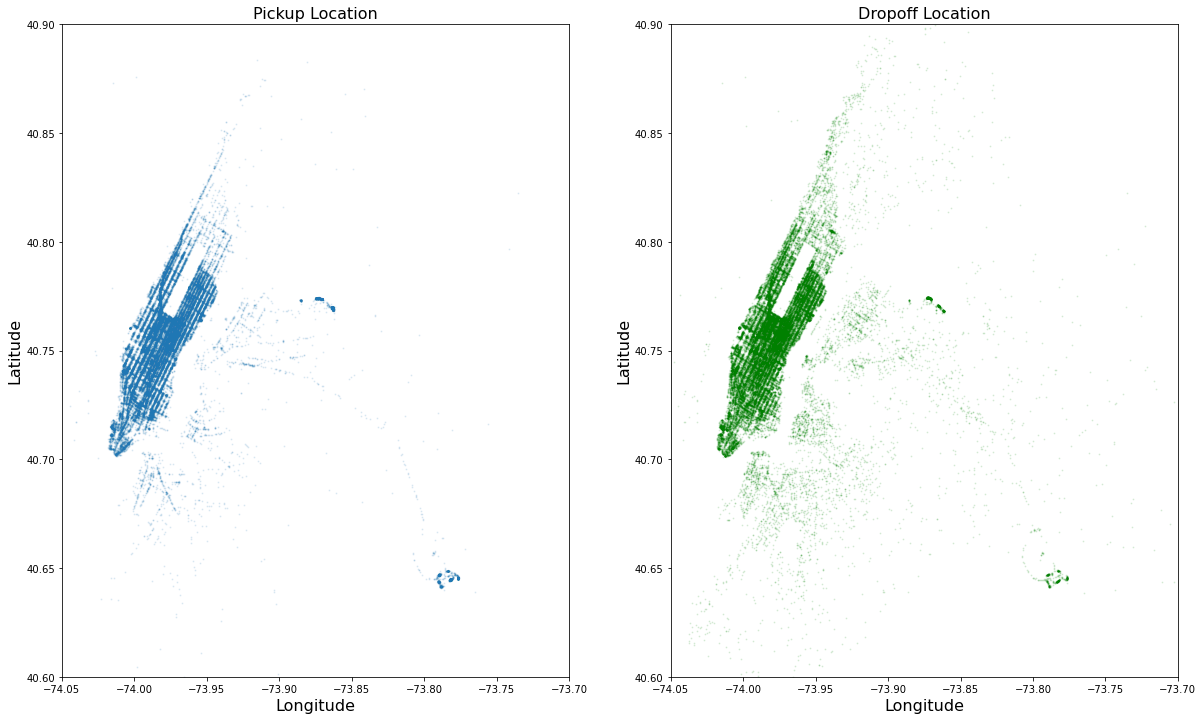

In [31]:
#code from Kaggle, available at: 
#https://www.kaggle.com/hanriver0618/nyc-taxi-data-exploration-visualization

fig = plt.figure(figsize=(20,12))
ax1 = fig.add_subplot(121)
ax1.scatter(df_trip.pickup_longitude,df_trip.pickup_latitude,s=1,alpha=0.1)
plt.ylim([40.60,40.90])
plt.xlim([-74.05,-73.70])
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('Pickup Location',fontsize=16)
ax2 = fig.add_subplot(122)
ax2.scatter(df_trip.dropoff_longitude,df_trip.dropoff_latitude,s=1,color='green',alpha=0.1)
plt.ylim([40.60,40.90])
plt.xlim([-74.05,-73.70])
plt.title('Dropoff Location',fontsize=16)
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)

Looking at the plot above, we can observe that most pickups are located in the neighborhood of Manhattan and not so much outside of it. In comparison, dropoffs are located not only in Manhattan but also further away than pickups. 

The majority of trips starts and ends in Manhattan, but a lot more dropoffs happen outside of Manhattan.

# 4. Machine Learning Models

## 4.1. More Data Preprocessing

To get our data ready for our machine learning models, we need to transform it some more. 

The first step is to encode the categorical variables so that they're no longer considered 'objects' and can be utilised in our regression analysis. We use the LabelEncoder() from sklearn to normalize our categorical variables. 

In [50]:
from sklearn import preprocessing

#creating a list of categorical variables
categorical_col = ['vendor_id', 'passenger_count', 'store_and_fwd_flag']

label_encoder = preprocessing.LabelEncoder()

#encoding the categorical variables
for col in categorical_col:
    df_trip[col] = label_encoder.fit_transform(df_trip[col])

The next step is to scale our dataset so that all our features are on a similar scale before feeding them to the models. For that we use StandardScaler() from sklearn and scale our numerical variables.

In [51]:
#creating a list of numerical variables
numerical_col = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'month', 'day_of_month', 'hour', 'day_of_week']

scaler = StandardScaler()

#scaling them
for col in numerical_col:
    df_trip[col] = scaler.fit_transform(df_trip[col].values.reshape(-1, 1))

Finally, we drop the columns that are redundant. For example, our pickup_datetime is captured in our month/day of the month/day of the week/hour variables and can be dropped. Similarly to pickup_date and dropoff_datetime. 

In [52]:
#drop useless columns
df_trip.drop(columns = ['log_trip_duration','pickup_date', 'pickup_datetime', 'dropoff_datetime'], inplace=True)

We now want to check for correlation between our variables. We create a heatmap of the correlation between all the variables in our dataset.

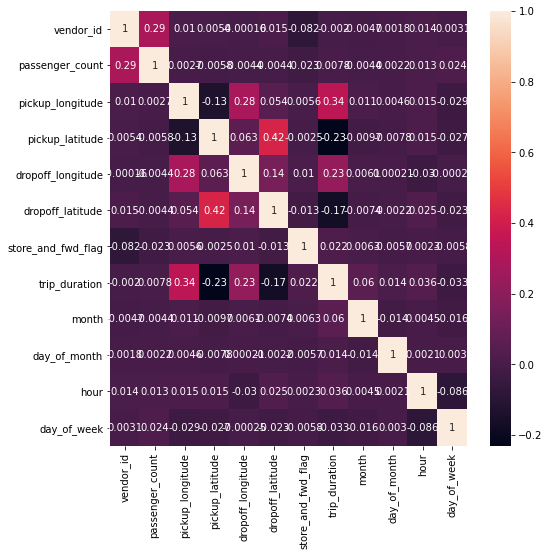

In [53]:
#checking for correlation amongst all the variables
fig,ax=plt.subplots(figsize=(8,8))
sns.heatmap(df_trip.corr(),annot=True)
plt.show()

The only variables that appear strongly correlated with our dependent variable are the pickup longitude and latitude and dropoff longitude and latitude. The other variables seem only slightly correlated with the duration of a trip. 
This could prove to be a limitation to our prediction analysis. 

Nevertheless, we are ready to split our train and test sets and start running our machine learning models. 

In [54]:
#split the dataset into train and test set
#split the labels
x = df_trip.drop(['trip_duration', 'id'], axis = 1)
y = df_trip[['trip_duration']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 42)

In [55]:
#check for the length of our train set
len(x_train)

39941

In [56]:
#also check for the length our test set 
len(x_test)

9986

In [57]:
#one last check to make sure everything adds up
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(39941, 11) (9986, 11) (39941, 1) (9986, 1)


In [58]:
#check our train set values
x_train.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,month,day_of_month,hour,day_of_week
48424,0,0,0.537,1.128,-0.420,0.064,0,-1.492,1.212,-0.723,-1.040
1187,0,0,0.331,0.191,0.005,0.181,0,-1.492,1.212,-1.037,-1.040
46087,0,0,4.794,-1.662,5.062,-2.073,0,-0.898,-0.980,0.374,1.511
32280,1,1,-0.173,-0.108,0.053,-0.234,0,0.883,-1.327,0.530,-0.530
49765,0,0,-0.522,0.188,-0.765,0.147,0,0.289,1.097,-0.096,-1.550


## 4.2. Linear Regression

We start by running a simple Linear Regression model to try and predict the duration of a trip.

The metrics of success we will use to measure the success of a model are Root-mean-squared-error (RMSE) and R-squared (R^2). 

In [36]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
y_pred_lin = lin_reg.predict(x_test)

In [37]:
from sklearn.metrics import mean_squared_error

print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred_lin)))

Root Mean Squared Error: 584.3669915067613


In [38]:
from sklearn.metrics import r2_score

print('R squared:', r2_score(y_test, y_pred_lin))

R squared: 0.19922238164763906


As can be seen above, our baseline model performs pretty poorly. The RMSE is pretty large which indicates poor fitting of our model on the data. On top of that, the R-squared value is only 0.20 which means that in this Linear Regression, our independent variables only explain 20% of the variance in our dependent variable. 

It was expected to see linear regression perform badly as it struggles to capture non-linear relationships. Let's see if we can improve our Linear Regression model by constraining the weights.

## 4.3. Elastic Net Regression

One way to constrain the model's weights is to run an Elastic Net regression.

In [39]:
from sklearn.linear_model import ElasticNet

enet_model = ElasticNet()
enet_model.fit(x_train, y_train)
y_pred_enet = enet_model.predict(x_test)

In [40]:
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test,y_pred_enet)))

Root Mean Squared Error: 589.9416681830913


In [41]:
print('R squared:', r2_score(y_test, y_pred_enet))

R squared: 0.18387117490003946


Elastic Net seems to have an even worse performance than our Linear Regression model. The RMSE is larger and the R-squared lower. Let's try and improve our Elastic Net regression by  finding the optimal alpha value (code from Kerem Kargin, 2021).

In [42]:
from sklearn.linear_model import ElasticNetCV

enet_cv_model = ElasticNetCV(cv = 10)
enet_cv_model.fit(x_train,y_train)

ElasticNetCV(cv=10)

In [43]:
enet_cv_model.alpha_

0.4519587539100889

The optimal alpha value appears to be 0.45. Let's input it in our new Elastic Net regression. 

In [44]:
enet_tuned = ElasticNet(alpha = enet_cv_model.alpha_)
enet_tuned.fit(x_train, y_train)
y_pred_enet_tuned = enet_tuned.predict(x_test)

In [45]:
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test,y_pred_enet_tuned)))

Root Mean Squared Error: 585.9015468754827


In [46]:
print('R squared:', r2_score(y_test, y_pred_enet_tuned))

R squared: 0.19501115451441442


Our Elastic Net regression improved only slightly when inputting the optimal alpha. However, even after being optimised, Elastic Net does not perform any better than Linear Regression. 

## 4.4. Ridge Regression

We now look at Ridge Regression to see if it would improve our Linear Regression model. 

In [47]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(penalty = "l2")
sgd_reg.fit(x_train, y_train)
sgd_pred_l1 = sgd_reg.predict(x_test)

In [48]:
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test,sgd_pred_l1)))

Root Mean Squared Error: 586.0830519417673


In [49]:
print('R squared:', r2_score(y_test, sgd_pred_l1))

R squared: 0.19451232604739455


Again, Ridge Regression has a poor performance. It is time to move from Linear Regressions and try models that may capture non-linear relationships better.

## 4.5. Decision Tree Regression

We now run a simple Decision Tree Regression and measure its performance.

In [84]:
from sklearn.tree import DecisionTreeRegressor 

tree_reg = DecisionTreeRegressor(random_state = 101)
tree_reg.fit(x_train, y_train)
y_pred_tree = tree_reg.predict(x_test)

In [85]:
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred_tree)))

Root Mean Squared Error: 466.9663862080305


In [86]:
print('R squared:', r2_score(y_test, y_pred_tree))

R squared: 0.4886575914605993


Decision Tree Regression performs much better than Linear Regression. RMSE has decreased by more than 100 seconds and R-squared has increased by 28%. 

Decision Tree Regression seems to fit the data better. This might be due to the model capturing the effect of independent categorial variables better than Linear Regression can. 

We seem to be going in the right direction.

## 4.6. Random Forests Regression

We now run a simple Random Forests Regression. 

In [81]:
from sklearn.ensemble import RandomForestRegressor

ran_forest_reg = RandomForestRegressor(random_state = 101)
ran_forest_reg.fit(x_train, y_train)
y_pred_forest = ran_forest_reg.predict(x_test)

In [82]:
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred_forest)))

Root Mean Squared Error: 328.5607930931218


In [83]:
print('R squared:', r2_score(y_test, y_pred_forest))

R squared: 0.7468534286619134


Random Forests has considerably reduced RMSE and increased R-squared to approximately 0.75. In this model, our independent variables explain 75% of the variance in our dependent variable. 

## 4.7. XGBoost Regression

We now run XGBoost Regression. This is a great model for regression and should hopefully give us a good prediction performance.

In [59]:
from xgboost.sklearn import XGBRegressor

xg_reg = XGBRegressor(random_state = 101)
xg_reg.fit(x_train, y_train)
y_pred_xg = xg_reg.predict(x_test)

In [61]:
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred_xg)))

Root Mean Squared Error: 325.3586411983054


In [63]:
print('R squared:', r2_score(y_test, y_pred_xg))

R squared: 0.7517637141925357


As can be seen above, XGBoost also performs well. The RMSE is decreased and the R-squared is slightly higher than our Random Forests regressor. 

This is the best model so far. Let's see if we can improve the performance of our models by combining them.

## 4.8. Voting Regressor

We combine our three best models: AdaBoostRegressor, RandomForestRegressor and DecisionTreeRegressor. 

In [286]:
from sklearn.ensemble import VotingRegressor

tree_votereg = DecisionTreeRegressor(random_state = 101)
rnd_votereg = RandomForestRegressor(random_state = 101)
xg_votereg = XGBRegressor()

voting_reg = VotingRegressor(
    estimators=[('tr', tree_votereg), ('rf', rnd_votereg), ('xg', xg_votereg)])
voting_reg.fit(x_train, y_train)

y_pred_votereg = voting_reg.predict(x_test)

In [287]:
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred_votereg)))

Root Mean Squared Error: 336.58799518265795


In [288]:
print('R squared:', r2_score(y_test, y_pred_votereg))

R squared: 0.7343328738367234


The Voting Regressor performs pretty well. R-squared is still lower than when running Random Forest and XGBoost on their own which may be due to the inclusion of the Decision Tree Regressor, which performs poorly on its own compared to the others.

Trying Voting Regressor with only the Random Forest and XGBoost regressors may yield better results in terms of low RMSE and high R-squared. 

In [93]:
#second round of voting regressor, with only 2 models this time
rnd_votereg_2 = RandomForestRegressor(random_state = 101)
xg_votereg_2 = XGBRegressor()

voting_reg_2 = VotingRegressor(
    estimators=[('rf', rnd_votereg_2), ('xg', xg_votereg_2)])
voting_reg_2.fit(x_train, y_train)

y_pred_votereg_2 = voting_reg_2.predict(x_test)

In [94]:
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred_votereg_2)))

Root Mean Squared Error: 316.71861099900843


In [95]:
print('R squared:', r2_score(y_test, y_pred_votereg_2))

R squared: 0.7647726903445171


The Voting Regressor does perform better when only using 2 models. It performs even better than both ran individually. We get a lower RMSE and a higher R-squared (an increase of 1% compared to XGBoost). 

# 5. Fine Tuning Models

We can now start fine tuning our 3 best models: RandomForestRegressor and XGBoostRegressor. 

## 5.1. Random Forests Fine-tuning

In [75]:
from sklearn.model_selection import GridSearchCV

#tuning random forests using grid search
ran_forest_param = {'n_estimators': [300, 500, 700, 1000],
            'max_features': ['auto', 'sqrt'],
            'max_depth': [50, 60, 70, 80, 90, 100],
            'bootstrap': [True]}

ran_forest_grid = GridSearchCV(ran_forest_reg, ran_forest_param, n_jobs=-1, cv=3, verbose=2, random_state = 101)

In [76]:
ran_forest_grid.fit(x_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True],
                         'max_depth': [50, 60, 70, 80, 90, 100],
                         'max_features': ['auto', 'sqrt'],
                         'n_estimators': [300, 500, 700, 1000]},
             verbose=2)

In [77]:
ran_forest_grid.best_params_

{'bootstrap': True,
 'max_depth': 60,
 'max_features': 'auto',
 'n_estimators': 1000}

In [78]:
ran_forest_tune = ran_forest_grid.best_estimator_ 
ran_forest_predict = ran_forest_tune.predict(x_test)

In [79]:
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, ran_forest_predict)))

Root Mean Squared Error: 326.0544582057733


In [80]:
print('R squared:', r2_score(y_test, ran_forest_predict))

R squared: 0.7507008149423842


After running GridSearch thrice and tweaking a few parameters each time, the best score was found above with an R-squared of 0.7507. It only slighlty increased from the simple Random Forest regression -- 0.39%.

RandomizedSearch was performed but didn't yield any better results. We move onto fine-tuning XGBoost.

## 5.2. XGBoost Fine-tuning

In [64]:
#tuning xgboost using grid search
xg_param = {"eta": [0.001, 0.01, 0.2], 
             "max_depth": [5, 6, 7],
            'n_estimators': [100, 200, 300]}

xg_rand = RandomizedSearchCV(xg_reg, xg_param, n_jobs=-1, n_iter = 10, cv=3, verbose=2, random_state = 101)

In [65]:
xg_rand.fit(x_train, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1,
                                          enable_categorical=False, gamma=0,
                                          gpu_id=-1, importance_type=None,
                                          interaction_constraints='',
                                          learning_rate=0.300000012,
                                          max_delta_step=0, max_depth=6,
                                          min_child_weight=1, missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=100, n_jobs=16,
                                          num_parallel_tree=1, predictor='auto',
                                          random_sta

In [66]:
xg_rand.best_params_

{'n_estimators': 100, 'max_depth': 7, 'eta': 0.2}

In [67]:
xg_tune = xg_rand.best_estimator_ 
xg_predict = xg_tune.predict(x_test)

In [68]:
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, xg_predict)))

Root Mean Squared Error: 324.03338719918395


In [69]:
print('R squared:', r2_score(y_test, xg_predict))

R squared: 0.7537818326287837


After running RandomizedSearch on XGboost Regressor thrice and tweaking a few parameters each time, the best score was found above with an R-squared of 0.7537. It only slighlty increased from the simple XGBoost Regressor -- 0.20%.

GridSearch was attempted but was too computationally exhausting. 

## 5.3. Voting Regressor on Tuned Models

We now run a Voting Regressor on our fine-tuned models. We will hopefully be able to get the best performance out of all of our models. 

In [84]:
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import VotingRegressor

rf_votereg_tune = RandomForestRegressor(bootstrap = True, max_depth = 60, max_features = 'auto', n_estimators = 1000,
                                       random_state = 101)
xg_votereg_tune = XGBRegressor(n_estimators = 100, max_depth = 7, eta = 0.2)

votereg_tune = VotingRegressor(
 estimators=[('rf', rf_votereg_tune), ('xg', xg_votereg_tune)])

votereg_tune.fit(x_train, y_train)

y_pred_votereg_tune = votereg_tune.predict(x_test)

In [85]:
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred_votereg_tune)))

Root Mean Squared Error: 315.6591497535841


In [86]:
print('R squared:', r2_score(y_test, y_pred_votereg_tune))

R squared: 0.7663437845857421


Our Voting Regressor model is the best so far. 

It, however, does not perform significantly better than our simple Voting Regressor on the un-tuned models. It increased by approximately 0.20%. 

This is probably the best fit for our model. The fact we cannot get higher performance results may be due to issues with the dataset itself.

# 6. Summary

We started by analysing our data which highlighted that the number of passenger, the time of the day and the dropoff and pickup locations all appeared to be correlated with trip duration. To further investigate, we have analysed 8 regression models with the aim of reducing RMSE and increasing R squared.

After running our models and fine-tuning a couple of them, the best performing model was the Voting Regressor which drew on our tuned Random Forest Regressor and XGBoost Regressor. With a RSME of 315 and an R-squared of 76.63%, this model seemed to fit our data the best and be able to predict the duration of a trip accurately enough.

# 7. Limitations

One of the first limitations of this analysis is the fact that we used only 50,000 rows of the whole dataset. Even though reducing the size of our dataset was best to optimise the runtime of our models, we may have missed out on some important observations. 

Moreover, we did not have a lot of variables and only a few of the variables we had were highly correlated with our dependent variable (as shown by the correlation matrix). More feature engineering or data enrichment using other datasets containing more starting points and distance measures could have potentially enhanced the performance of our models.

Finally, because some models were too computationally exhausting, we could not run them (such as Vector Support Regression or Search Grid for tuning XGBoost hyperparameters.

# 8. References

Kargin K. (2021) ElasticNet Regression Fundamentals and Modeling in Python. Available at: https://medium.com/mlearning-ai/elasticnet-regression-fundamentals-and-modeling-in-python-8668f3c2e39e [Accessed: 7 March 2022]

Dataset available at: https://www.kaggle.com/c/nyc-taxi-trip-duration/data [Accessed: 22 February 2022]